In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
malware_df = []
benign_df = []

malwares = ['shade-ransomware','meterpreter','poshc2']
benigns = ['google','web-browse']

for mal in malwares:
    with open(f"./{mal}/spl.log") as fl:
        malware_df.append(pd.read_json(fl, lines=True))

for name in benigns:
    with open(f"./{name}/spl.log") as fl:
        benign_df.append(pd.read_json(fl, lines=True))

In [3]:
malware_df = pd.concat(malware_df)
benign_df = pd.concat(benign_df)

In [6]:
malware_df['label'] = True
benign_df['label'] = False
df = pd.concat([malware_df,benign_df])
df = df.fillna(0)

def get_column_max(row, col):
    if col in row:
        if not isinstance(row[col],list):
            return row[col]
        return max(row[col])
    return 0
    
def get_column_min(row, col):
    if col in row:
        if not isinstance(row[col],list):
            return row[col]
        return max(row[col])
    return 0
    
def get_column_avg(row, col):
    if col in row:
        if not isinstance(row[col],list):
            return row[col]
        return sum(row[col]) / len(row[col])
    return 0

def get_column_p_avg(row, col, l_p, t_p):
    if col in row:
        if not isinstance(row[col],list):
            return row[col]
        
        arr_size = len(row[col])
        # Sort a copy so we don't modify the array
        sort_arr = row[col].copy()
        sort_arr.sort()
        top_10pct_arr = sort_arr[int(arr_size * l_p):int(arr_size * t_p)]
        return sum(top_10pct_arr) / (1 if len(top_10pct_arr) == 0 else len(top_10pct_arr))
    return 0

df['max_orig_spl'] = df.apply(lambda row: get_column_max(row, 'orig_spl'), axis=1)
df['min_orig_spl'] = df.apply(lambda row: get_column_min(row, 'orig_spl'), axis=1)
df['avg_orig_spl'] = df.apply(lambda row: get_column_avg(row, 'orig_spl'), axis=1)
df['top_10p_avg_orig_spl'] = df.apply(lambda row: get_column_p_avg(row, 'orig_spl', 0.9, 1), axis=1)
df['bot_80p_avg_orig_spl'] = df.apply(lambda row: get_column_p_avg(row, 'orig_spl', 0, 0.8), axis=1)


df['max_resp_spl'] = df.apply(lambda row: get_column_max(row, 'resp_spl'), axis=1)
df['min_resp_spl'] = df.apply(lambda row: get_column_min(row, 'resp_spl'), axis=1)
df['avg_resp_spl'] = df.apply(lambda row: get_column_avg(row, 'resp_spl'), axis=1)
df['top_10p_avg_resp_spl'] = df.apply(lambda row: get_column_p_avg(row, 'resp_spl', 0.9, 1), axis=1)
df['bot_80p_avg_resp_spl'] = df.apply(lambda row: get_column_p_avg(row, 'resp_spl', 0, 0.8), axis=1)



In [8]:
from sklearn import tree
from sklearn.model_selection import train_test_split

model = tree.DecisionTreeClassifier(random_state=97)

y = df['label']

mod_df = df[['max_orig_spl','min_orig_spl','avg_orig_spl','top_10p_avg_orig_spl','bot_80p_avg_orig_spl',
             'max_resp_spl','min_resp_spl','avg_resp_spl','top_10p_avg_resp_spl','bot_80p_avg_resp_spl']]

X = dict()
Y = dict()


X['train'], X['test'], Y['train'], Y['test'] = train_test_split(mod_df, y, test_size=0.3)

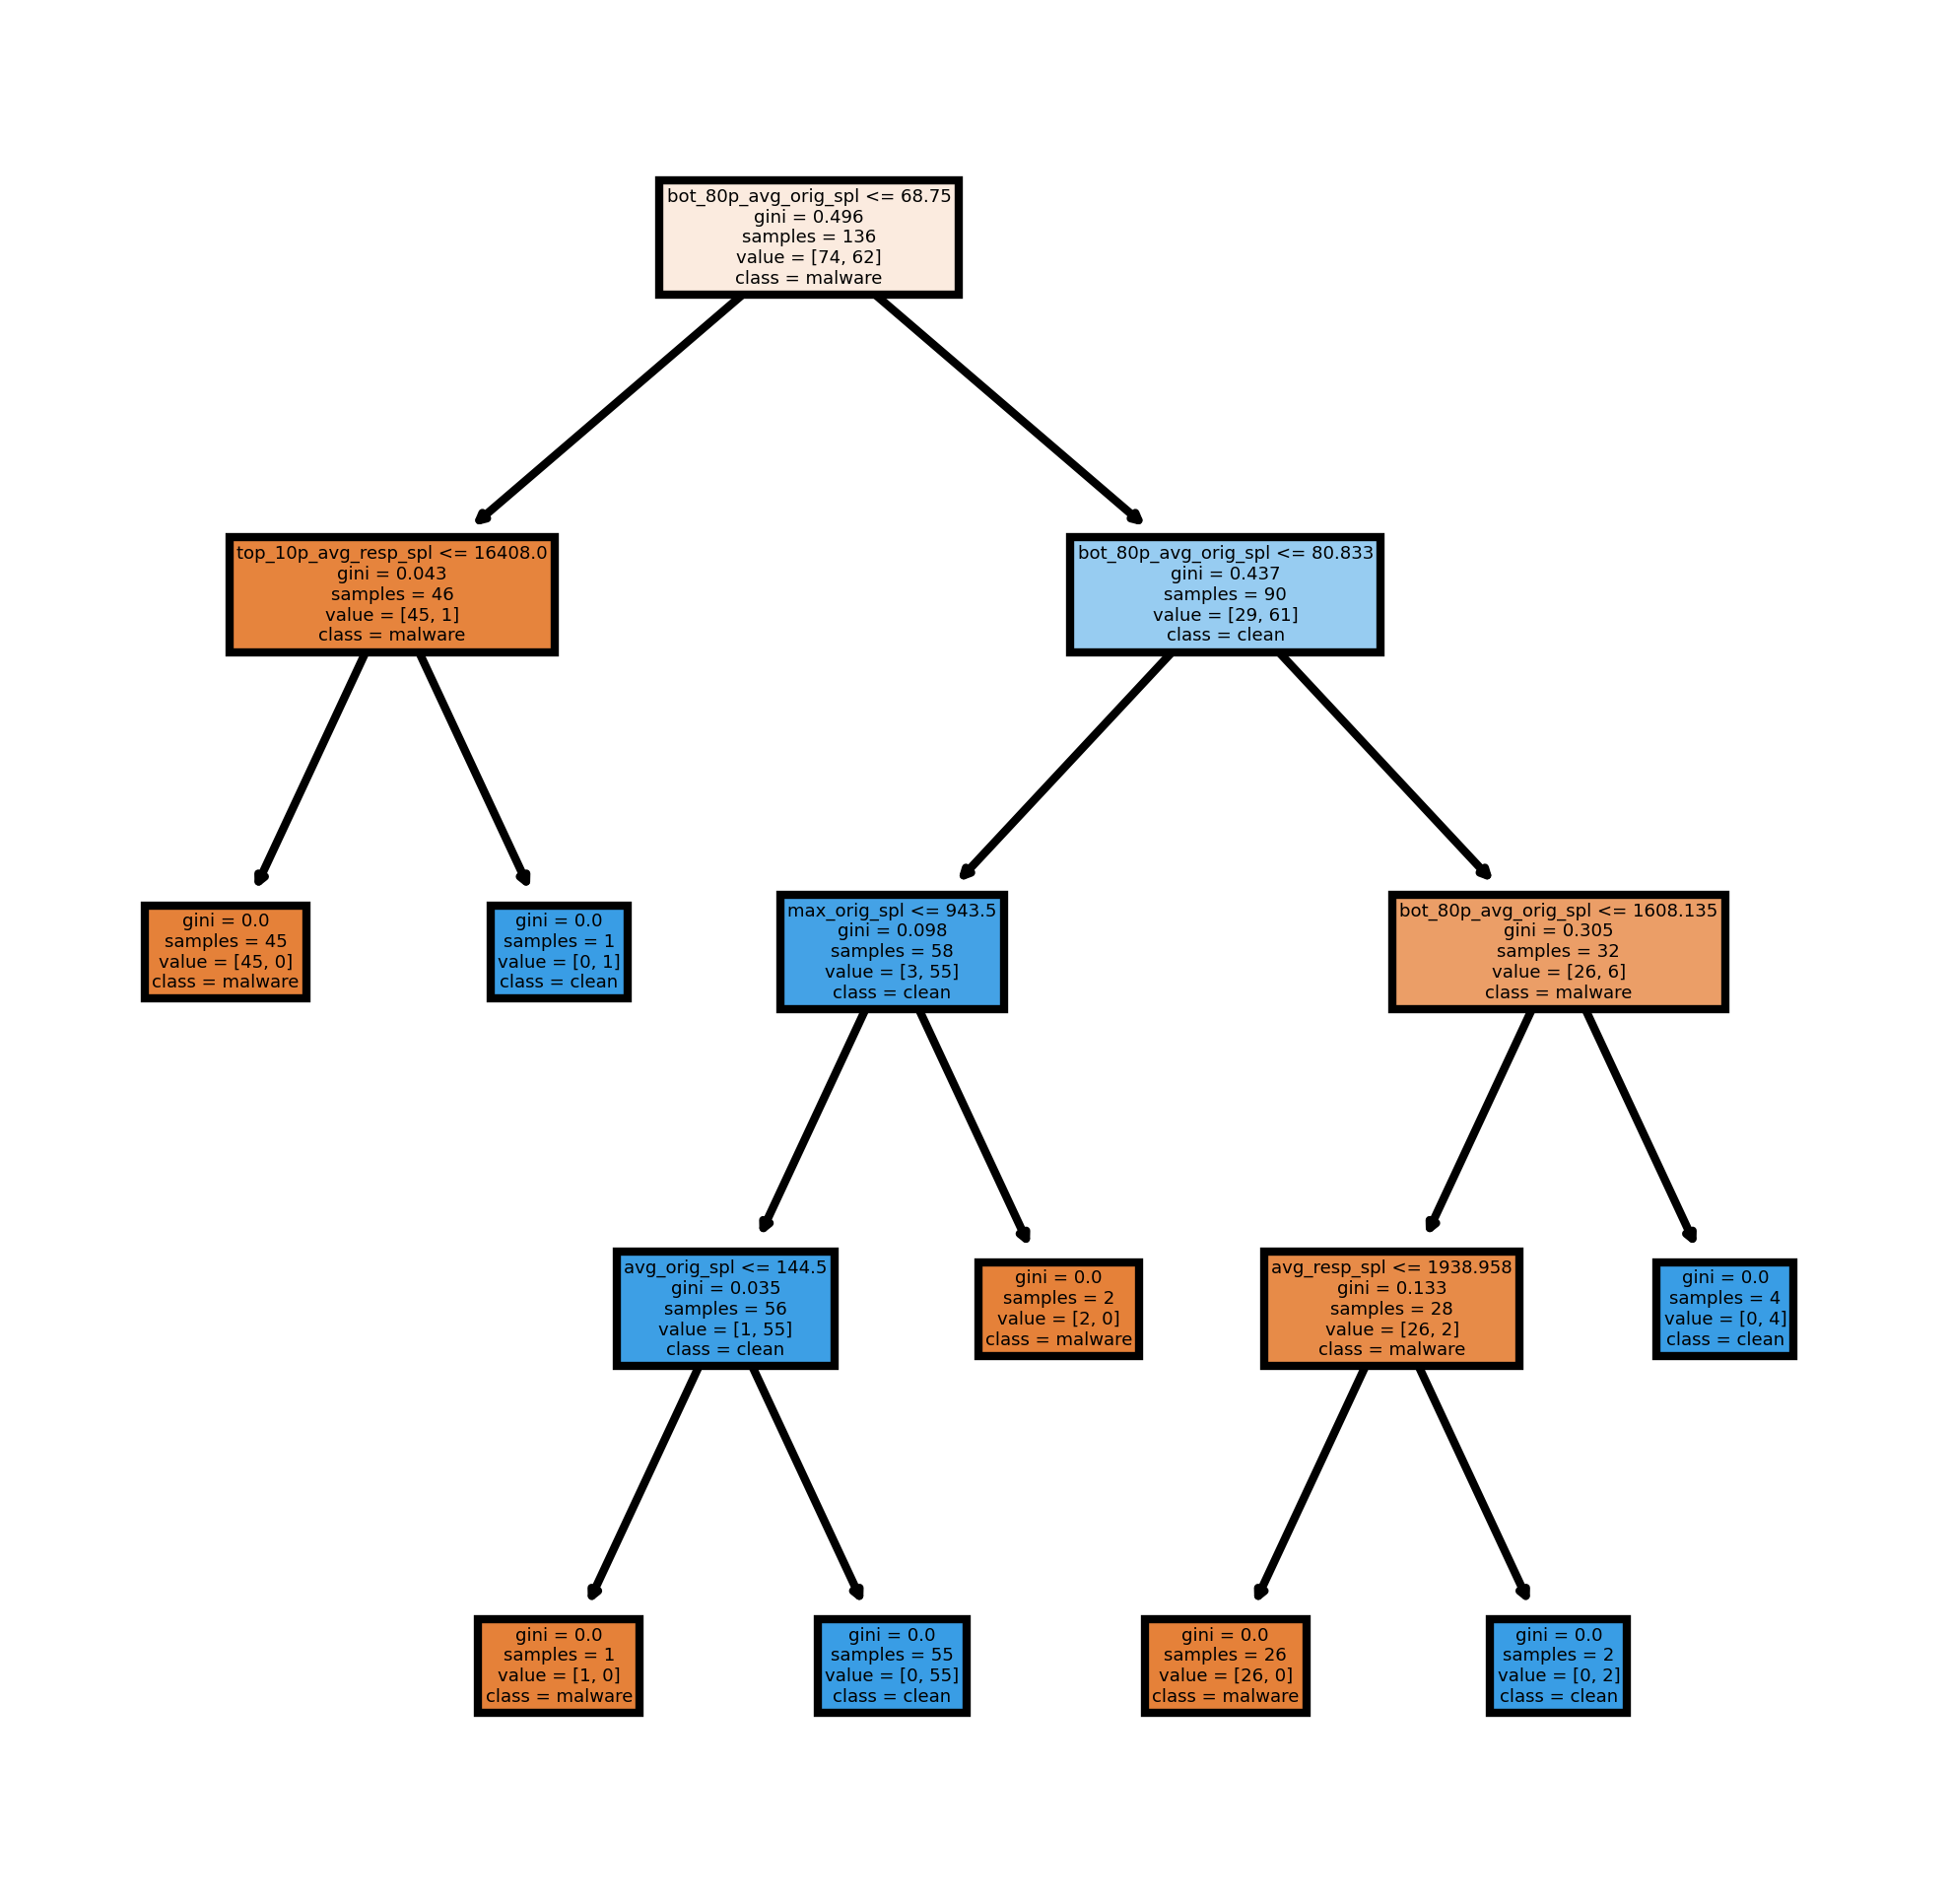

In [9]:
model = model.fit(X['train'], Y['train'])

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(model, feature_names=mod_df.columns, class_names=['malware','clean'], filled=True)
fig.savefig("decision-tree.png")

In [10]:
y_pred = model.predict(X['test'])

In [12]:
from sklearn import metrics



print("Testing models over 1000 iterations...")
print(f"Test data sample size: {len(X['test'])}\n")

min_acc = float("inf")
max_acc = 0
max_fp = 0
max_fn = 0
for _ in range(0,1000):
    test_df = mod_df[['max_orig_spl','min_orig_spl','avg_orig_spl','bot_80p_avg_orig_spl',
                      'max_resp_spl','min_resp_spl','avg_resp_spl','bot_80p_avg_resp_spl']]
    X['train'], X['test'], Y['train'], Y['test'] = train_test_split(test_df, y, test_size=0.3)
    t_mod = tree.DecisionTreeClassifier()
    t_mod = t_mod.fit(X['train'], Y['train'])

    y_pred = t_mod.predict(X['test'])
    
    min_acc = min(min_acc, metrics.accuracy_score(Y['test'], y_pred))
    max_acc = max(max_acc, metrics.accuracy_score(Y['test'], y_pred))
    
    CM = metrics.confusion_matrix(Y['test'], y_pred)
    max_fp = max(max_fp, CM[0][1])
    max_fn = max(max_fn, CM[1][0])

print("Results with top 10 percentile average...")
print(f"Max accuracy :\t\t{max_acc}")
print(f"Min accuracy :\t\t{min_acc}")
print(f"Max false negative:\t{max_fn/len(X['test'])}\t{max_fn}")
print(f"Max false positive:\t{max_fp/len(X['test'])}\t{max_fp}")

min_acc = float("inf")
max_acc = 0
max_fp = 0
max_fn = 0
for _ in range(0,1000):
    test_df = mod_df[['max_orig_spl','min_orig_spl','avg_orig_spl','bot_80p_avg_orig_spl',
                      'max_resp_spl','min_resp_spl','avg_resp_spl','bot_80p_avg_resp_spl']]
    X['train'], X['test'], Y['train'], Y['test'] = train_test_split(test_df, y, test_size=0.3)
    t_mod = tree.DecisionTreeClassifier()
    t_mod = t_mod.fit(X['train'], Y['train'])

    y_pred = t_mod.predict(X['test'])
    
    min_acc = min(min_acc, metrics.accuracy_score(Y['test'], y_pred))
    max_acc = max(max_acc, metrics.accuracy_score(Y['test'], y_pred))
    
    CM = metrics.confusion_matrix(Y['test'], y_pred)
    max_fp = max(max_fp, CM[0][1])
    max_fn = max(max_fn, CM[1][0])

print("Results with bot 80 percentile average...")
print(f"Max accuracy :\t\t{max_acc}")
print(f"Min accuracy :\t\t{min_acc}")
print(f"Max false negative:\t{max_fn/len(X['test'])}\t{max_fn}")
print(f"Max false positive:\t{max_fp/len(X['test'])}\t{max_fp}")

min_acc = float("inf")
max_acc = 0
max_fp = 0
max_fn = 0
for _ in range(0,1000):
    test_df = mod_df[['max_orig_spl','min_orig_spl','avg_orig_spl',
                      'max_resp_spl','min_resp_spl','avg_resp_spl']]
    X['train'], X['test'], Y['train'], Y['test'] = train_test_split(test_df, y, test_size=0.3)
    t_mod = tree.DecisionTreeClassifier()
    t_mod = t_mod.fit(X['train'], Y['train'])

    y_pred = t_mod.predict(X['test'])
    
    min_acc = min(min_acc, metrics.accuracy_score(Y['test'], y_pred))
    max_acc = max(max_acc, metrics.accuracy_score(Y['test'], y_pred))
    
    CM = metrics.confusion_matrix(Y['test'], y_pred)
    max_fp = max(max_fp, CM[0][1])
    max_fn = max(max_fn, CM[1][0])

print("Results with just min/max/avg...")
print(f"Max accuracy :\t\t{max_acc}")
print(f"Min accuracy :\t\t{min_acc}")
print(f"Max false negative:\t{max_fn/len(X['test'])}\t{max_fn}")
print(f"Max false positive:\t{max_fp/len(X['test'])}\t{max_fp}")

min_acc = float("inf")
max_acc = 0
max_fp = 0
max_fn = 0
for _ in range(0,1000):
    test_df = mod_df
    X['train'], X['test'], Y['train'], Y['test'] = train_test_split(test_df, y, test_size=0.3)
    t_mod = tree.DecisionTreeClassifier()
    t_mod = t_mod.fit(X['train'], Y['train'])

    y_pred = t_mod.predict(X['test'])
    
    min_acc = min(min_acc, metrics.accuracy_score(Y['test'], y_pred))
    max_acc = max(max_acc, metrics.accuracy_score(Y['test'], y_pred))
    
    CM = metrics.confusion_matrix(Y['test'], y_pred)
    max_fp = max(max_fp, CM[0][1])
    max_fn = max(max_fn, CM[1][0])

print("Results with all features...")
print(f"Max accuracy :\t\t{max_acc}")
print(f"Min accuracy :\t\t{min_acc}")
print(f"Max false negative:\t{max_fn/len(X['test'])}\t{max_fn}")
print(f"Max false positive:\t{max_fp/len(X['test'])}\t{max_fp}")

Testing models over 1000 iterations...
Test data sample size: 59

Results with top 10 percentile average...
Max accuracy :		1.0
Min accuracy :		0.847457627118644
Max false negative:	0.11864406779661017	7
Max false positive:	0.11864406779661017	7
Results with bot 80 percentile average...
Max accuracy :		1.0
Min accuracy :		0.7966101694915254
Max false negative:	0.13559322033898305	8
Max false positive:	0.1864406779661017	11
Results with just min/max/avg...
Max accuracy :		1.0
Min accuracy :		0.7796610169491526
Max false negative:	0.15254237288135594	9
Max false positive:	0.15254237288135594	9
Results with all features...
Max accuracy :		1.0
Min accuracy :		0.8305084745762712
Max false negative:	0.11864406779661017	7
Max false positive:	0.13559322033898305	8


In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(estimator=model, X=X['train'], y=Y['train'])

array([1.        , 0.92592593, 0.85185185, 0.92592593, 0.92592593])

In [10]:
X['test']

,max_orig_spl,min_orig_spl,avg_orig_spl,max_resp_spl,min_resp_spl,avg_resp_spl,max_orig_spt,min_orig_spt,avg_orig_spt,max_resp_spt,min_resp_spt,avg_resp_spt
69,1130,1130,585.000000,16384,16384,8135.900000,0.001051,0.001051,0.000525,0.645878,0.645878,0.065784
68,320,320,200.000000,176,176,106.666667,0.000118,0.000118,0.000059,0.000494,0.000494,0.000183
32,320,320,200.000000,320,320,154.666667,0.000119,0.000119,0.000059,0.000875,0.000875,0.000313
68,223,223,79.500000,2536,2536,1133.300000,2.451112,2.451112,0.248841,0.032109,0.032109,0.002195
40,320,320,200.000000,176,176,106.666667,0.000110,0.000110,0.000055,0.000653,0.000653,0.000241
11,544,544,312.000000,176,176,106.666667,0.000135,0.000135,0.000067,0.000596,0.000596,0.000216
52,320,320,200.000000,176,176,106.666667,0.000111,0.000111,0.000055,0.000585,0.000585,0.000215
35,320,320,200.000000,176,176,106.666667,0.000108,0.000108,0.000054,0.100822,0.100822,0.033627
19,0,0,0.000000,2537,2537,2537.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46,320,320,200.000000,176,176,106.666667,0.000105,0.000105,0.000053,0.000672,0.000672,0.000243
